# Table of Contents
- [Data Cleaning](#data-cleaning)
- [Data Exploration and Visualization](#data-exploration-and-visualization)
    - [Neighborhood Pricing](#neighborhood-pricing)
    - [Number of Listings Per Neighborhood](#number-of-listings-per-neighborhood)
    - [Holidays Analysis](#holidays)
    - [Days of the Week Analysis](#days-of-the-week)
    - [Does a host's number of listings impact their listings' ratings?](#host-listings)
    - [Impact of Various Variables on Price](#variables-price)

In [1]:
import os
import os.path
import time
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2024-03-06 19:07:46.971329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
listings = pd.read_csv(r'/Users/puddl/Desktop/Portfolio_Project/listings.csv')
calendar = pd.read_csv(r'/Users/puddl/Desktop/Portfolio_Project/calendar.csv')

<a id='data-cleaning'></a>

## Data Cleaning

In [3]:
listings.head()

,id,name,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,956883,Maija,8/11/11,within a few hours,96%,100%,f,3.0,...,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,5177328,Andrea,2/21/13,within an hour,98%,100%,t,6.0,...,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,6,1.48
2,3308979,New Modern House-Amazing water view,16708587,Jill,6/12/14,within a few hours,67%,100%,f,2.0,...,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,2,1.15
3,7421966,Queen Anne Chateau,9851441,Emily,11/6/13,NaN,NaN,NaN,f,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,1,NaN
4,278830,Charming craftsman 3 bdm house,1452570,Emily,11/29/11,within an hour,100%,NaN,f,2.0,...,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,1,0.89


In [4]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


#### Check host_acceptance_rate column for more than one unique value. If it's only 100% and N/A, it can be dropped.

In [5]:
listings['host_acceptance_rate'].unique()

array(['100%', nan, '0%'], dtype=object)

In [6]:
listings['host_acceptance_rate'].value_counts()

100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64

In [7]:
listings.drop(columns=['host_acceptance_rate'], inplace=True)

#### Check square_feet column for values. If it's almost entirely empty, we can drop it.

In [8]:
listings['square_feet'].isnull().sum()

3721

In [9]:
listings['square_feet'].notnull().sum()

97

In [10]:
# Only about 3% of cells have values. That's not enough data to use in any meaningful way, so we can drop this column.
listings.drop(columns=['square_feet'], inplace=True)

#### Fill N/A cells with values. First, do the host_response_rate column. Fill each N/A cell with the average.

In [11]:
# Convert 'host_response_rate' column to numeric by removing '%' and converting to float
listings['host_response_rate'] = listings['host_response_rate'].str.rstrip('%').astype(float)

In [12]:
# Calculate the average response rate
average_response_rate = listings['host_response_rate'].mean()

In [13]:
# Impute the average into N/A cells in 'host_response_rate' column
listings['host_response_rate'].fillna(average_response_rate, inplace=True)

In [14]:
listings.head()

,id,name,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,956883,Maija,8/11/11,within a few hours,96.000000,f,3.0,3.0,...,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,5177328,Andrea,2/21/13,within an hour,98.000000,t,6.0,6.0,...,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,6,1.48
2,3308979,New Modern House-Amazing water view,16708587,Jill,6/12/14,within a few hours,67.000000,f,2.0,2.0,...,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,2,1.15
3,7421966,Queen Anne Chateau,9851441,Emily,11/6/13,NaN,94.886798,f,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,1,NaN
4,278830,Charming craftsman 3 bdm house,1452570,Emily,11/29/11,within an hour,100.000000,f,2.0,2.0,...,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,1,0.89


In [15]:
# Drop calculated_host_listings_count. It looks like inaccurate information of a previous column.
listings.drop(columns=['calculated_host_listings_count'], inplace=True)

<a id='data-exploration-and-visualization'></a>

# Data Exploration and Visualization

<a id='neighborhood-pricing'></a>

## Neighborhood Pricing

#### We should compare the average price for each neighborhood each day.

In [16]:
# Merge on 'listing_id'
merged_data = pd.merge(calendar, listings[['id', 'neighborhood']], left_on='listing_id', right_on='id')

In [17]:
# Clean calendar data by removing rows with missing prices
merged_data = merged_data.dropna(subset=['price'])

In [18]:
# Clean price data by removing non-numeric characters and converting to numeric
merged_data['price'] = merged_data['price'].replace('[\$,]', '', regex=True).astype(float)

In [19]:
# Convert date column to datetime format
merged_data['date'] = pd.to_datetime(merged_data['date'])

In [20]:
# Calculate average daily price for each neighborhood to use in graph
average_prices = merged_data.groupby(['neighborhood', 'date'])['price'].mean().reset_index()

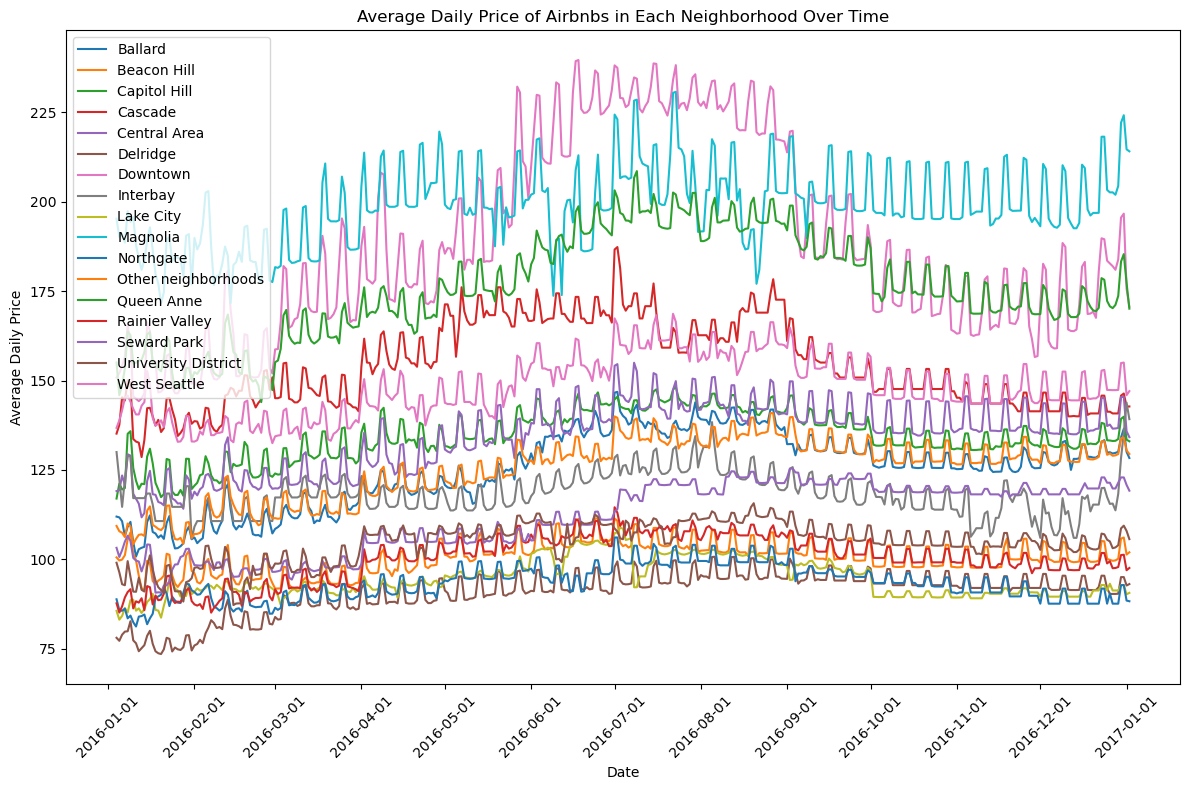

In [21]:
from matplotlib.dates import DateFormatter

plt.figure(figsize=(12, 8))

for neighborhood in average_prices['neighborhood'].unique():
    neighborhood_data = average_prices[average_prices['neighborhood'] == neighborhood]
    plt.plot(neighborhood_data['date'], neighborhood_data['price'], label=neighborhood)

plt.title('Average Daily Price of Airbnbs in Each Neighborhood Over Time')
plt.xlabel('Date')
plt.ylabel('Average Daily Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(bymonthday=1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Let's see if there is a different pattern for Airbnbs with different room types.

In [22]:
# First check for different types of values
listings['room_type'].value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [23]:
listings['room_type'].isnull().sum()

0

In [24]:
merged_data = pd.merge(calendar, listings[['id', 'neighborhood', 'room_type']], left_on='listing_id', right_on='id')

merged_data = merged_data.dropna(subset=['price'])

merged_data['price'] = merged_data['price'].replace('[\$,]', '', regex=True).astype(float)

merged_data['date'] = pd.to_datetime(merged_data['date'])

average_prices = merged_data.groupby(['neighborhood', 'room_type', 'date'])['price'].mean().reset_index()

### Private room

(array([16801., 16832., 16861., 16892., 16922., 16953., 16983., 17014.,
        17045., 17075., 17106., 17136., 17167.]),
 [Text(16801.0, 0, '2016-01-01'),
  Text(16832.0, 0, '2016-02-01'),
  Text(16861.0, 0, '2016-03-01'),
  Text(16892.0, 0, '2016-04-01'),
  Text(16922.0, 0, '2016-05-01'),
  Text(16953.0, 0, '2016-06-01'),
  Text(16983.0, 0, '2016-07-01'),
  Text(17014.0, 0, '2016-08-01'),
  Text(17045.0, 0, '2016-09-01'),
  Text(17075.0, 0, '2016-10-01'),
  Text(17106.0, 0, '2016-11-01'),
  Text(17136.0, 0, '2016-12-01'),
  Text(17167.0, 0, '2017-01-01')])

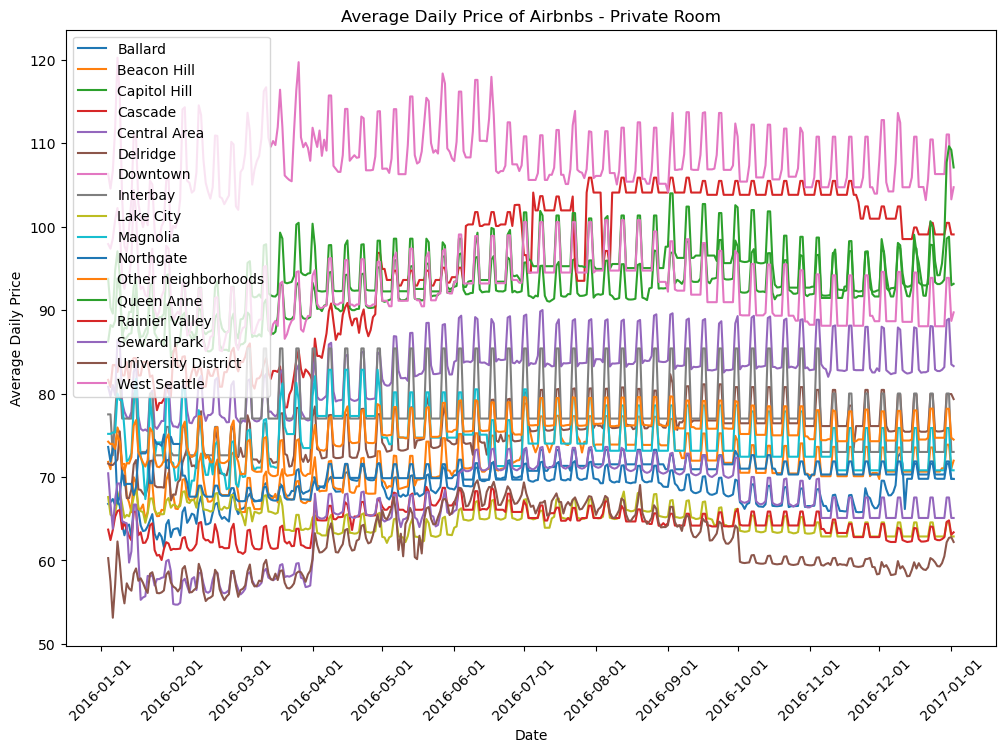

In [25]:
plt.figure(figsize=(12, 8))
plt.title('Average Daily Price of Airbnbs - Private Room')
for neighborhood in average_prices[average_prices['room_type'] == 'Private room']['neighborhood'].unique():
    neighborhood_data = average_prices[(average_prices['neighborhood'] == neighborhood) & (average_prices['room_type'] == 'Private room')]
    plt.plot(neighborhood_data['date'], neighborhood_data['price'], label=neighborhood)
plt.xlabel('Date')
plt.ylabel('Average Daily Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(bymonthday=1)) 
plt.xticks(rotation=45)

### Shared room

(array([16801., 16832., 16861., 16892., 16922., 16953., 16983., 17014.,
        17045., 17075., 17106., 17136., 17167.]),
 [Text(16801.0, 0, '2016-01-01'),
  Text(16832.0, 0, '2016-02-01'),
  Text(16861.0, 0, '2016-03-01'),
  Text(16892.0, 0, '2016-04-01'),
  Text(16922.0, 0, '2016-05-01'),
  Text(16953.0, 0, '2016-06-01'),
  Text(16983.0, 0, '2016-07-01'),
  Text(17014.0, 0, '2016-08-01'),
  Text(17045.0, 0, '2016-09-01'),
  Text(17075.0, 0, '2016-10-01'),
  Text(17106.0, 0, '2016-11-01'),
  Text(17136.0, 0, '2016-12-01'),
  Text(17167.0, 0, '2017-01-01')])

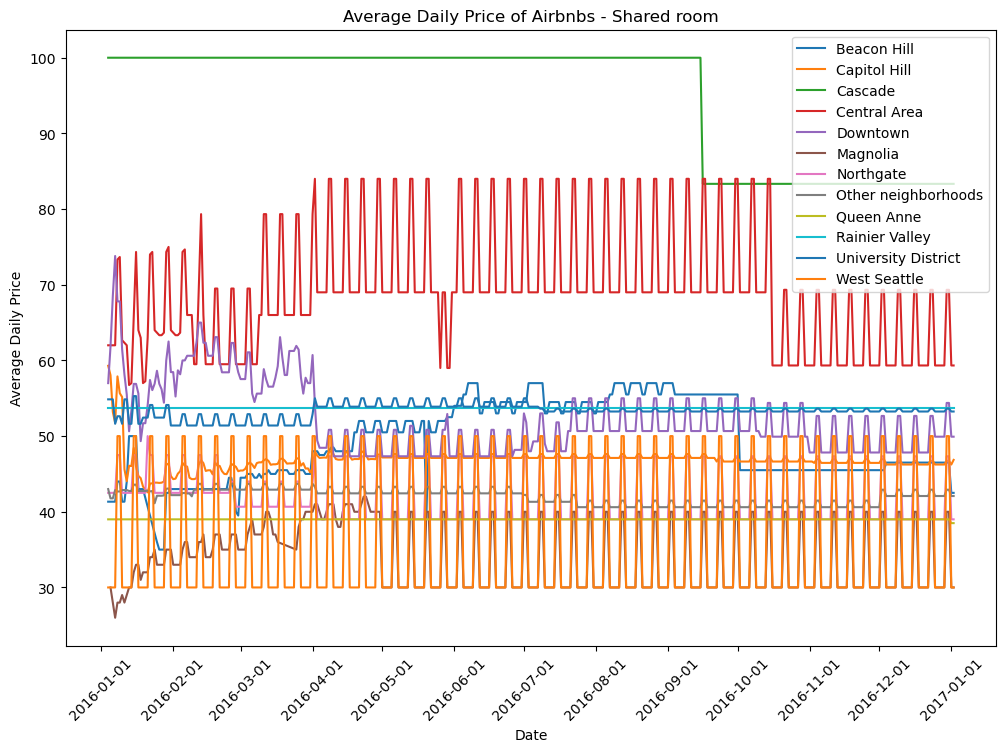

In [26]:
plt.figure(figsize=(12, 8))
plt.title('Average Daily Price of Airbnbs - Shared room')
for neighborhood in average_prices[average_prices['room_type'] == 'Shared room']['neighborhood'].unique():
    neighborhood_data = average_prices[(average_prices['neighborhood'] == neighborhood) & (average_prices['room_type'] == 'Shared room')]
    plt.plot(neighborhood_data['date'], neighborhood_data['price'], label=neighborhood)
plt.xlabel('Date')
plt.ylabel('Average Daily Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(bymonthday=1)) 
plt.xticks(rotation=45)

### Entire home/apt

(array([16801., 16832., 16861., 16892., 16922., 16953., 16983., 17014.,
        17045., 17075., 17106., 17136., 17167.]),
 [Text(16801.0, 0, '2016-01-01'),
  Text(16832.0, 0, '2016-02-01'),
  Text(16861.0, 0, '2016-03-01'),
  Text(16892.0, 0, '2016-04-01'),
  Text(16922.0, 0, '2016-05-01'),
  Text(16953.0, 0, '2016-06-01'),
  Text(16983.0, 0, '2016-07-01'),
  Text(17014.0, 0, '2016-08-01'),
  Text(17045.0, 0, '2016-09-01'),
  Text(17075.0, 0, '2016-10-01'),
  Text(17106.0, 0, '2016-11-01'),
  Text(17136.0, 0, '2016-12-01'),
  Text(17167.0, 0, '2017-01-01')])

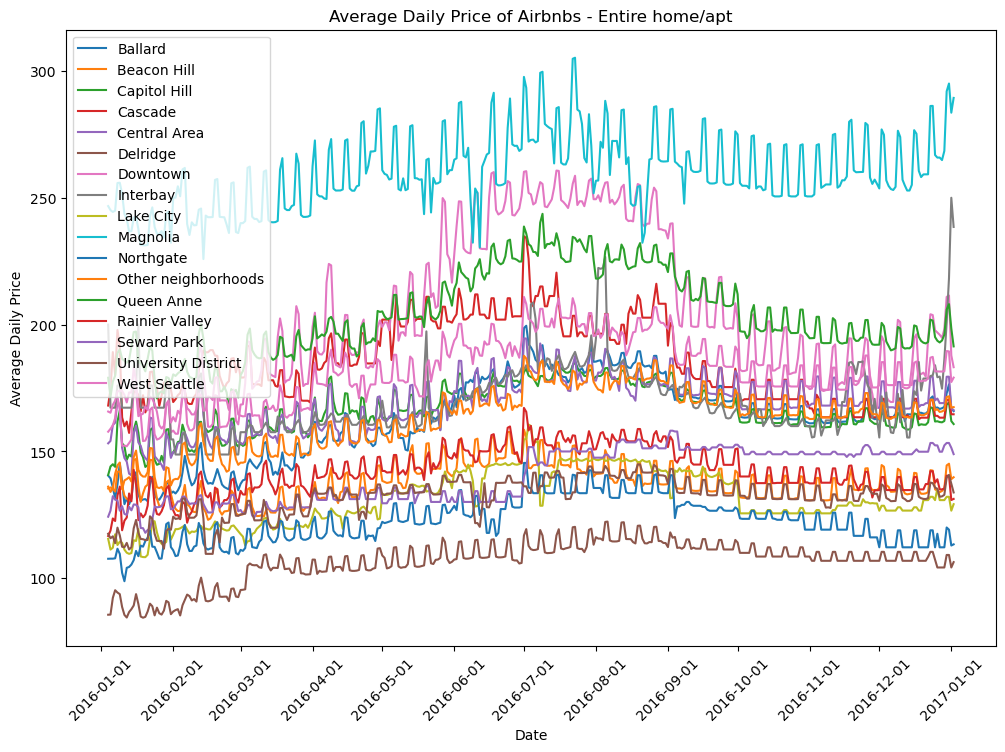

In [27]:
plt.figure(figsize=(12, 8))
plt.title('Average Daily Price of Airbnbs - Entire home/apt')
for neighborhood in average_prices[average_prices['room_type'] == 'Entire home/apt']['neighborhood'].unique():
    neighborhood_data = average_prices[(average_prices['neighborhood'] == neighborhood) & (average_prices['room_type'] == 'Entire home/apt')]
    plt.plot(neighborhood_data['date'], neighborhood_data['price'], label=neighborhood)
plt.xlabel('Date')
plt.ylabel('Average Daily Price')
plt.legend()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(bymonthday=1)) 
plt.xticks(rotation=45)

### Takeaways
#### Downtown is the most expensive over the summer, but Magnolia seems to be the most expensive any other time. It does appear that getting your own private room in Magnolia can get you a decent price when compared to other options. Renting an entire apartment or home is where Magnolia becomes much more expensive than other Seattle neighborhoods. The opposite appears to be true for Downtown — the price of entire homes/apts is relatively competitive with other Seattle neighborhoods, at least during summer months, but private rooms are way more expensive.

<a id='number-of-listings-per-neighborhood'></a>

## Number of Listings Per Neighborhood

#### Let's look into the number of Airbnbs per neighborhood.

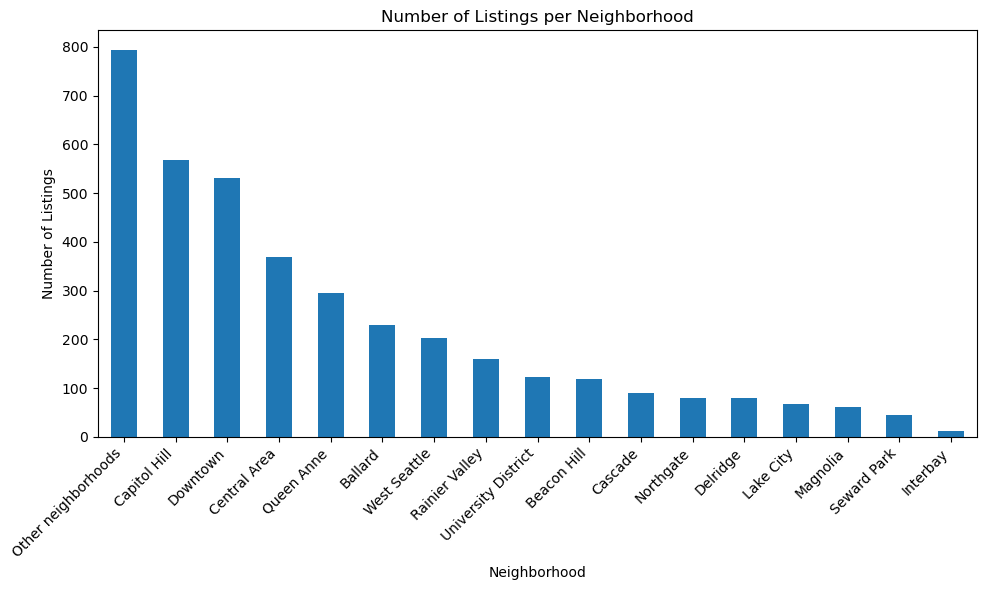

In [28]:
listings_per_neighborhood = listings['neighborhood'].value_counts()

plt.figure(figsize=(10, 6))
listings_per_neighborhood.plot(kind='bar')
plt.title('Number of Listings per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

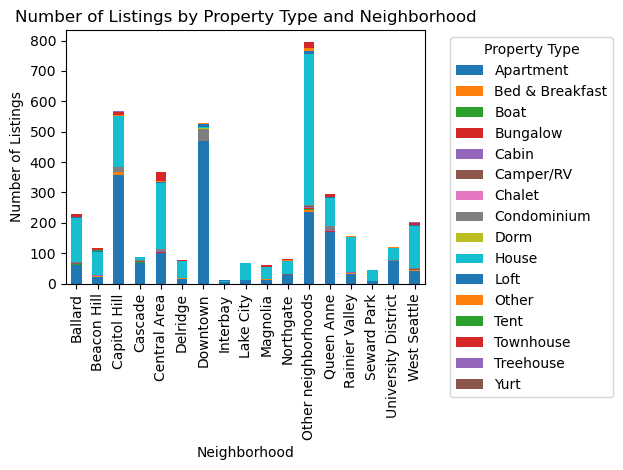

In [29]:
listings_per_neighborhood_and_property_type = listings.groupby(['neighborhood', 'property_type']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
ax = listings_per_neighborhood_and_property_type.plot(kind='bar', stacked=True)
plt.title('Number of Listings by Property Type and Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')
plt.xticks(rotation=90, ha='center')
plt.legend(title='Property Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Takeaways
#### Aside from Other Neighborhoods, Capitol Hill and Downtown dominate this dataset. Both have incredibly high percentages of apartments. Houses make up the bulk of most of the other neighborhoods such as West Seattle and Ballard. Houses are also the plurality in the Other Neighborhoods section.

<a id='holidays'></a>

## When are the best holidays to book a stay?

#### Let's first look at the average price for each holiday among all listings. We'll create a holiday dictionary and then create a bar chart of the holiday averages.

/var/folders/l3/c7dty6cx0yv5s4ldhyjnv1hh0000gn/T/ipykernel_4482/233394887.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  holiday_data['price_x'] = holiday_data['price_x'].str.replace(',', '').str.replace('$', '').astype(float)
/var/folders/l3/c7dty6cx0yv5s4ldhyjnv1hh0000gn/T/ipykernel_4482/233394887.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holiday_data['price_x'] = holiday_data['price_x'].str.replace(',', '').str.replace('$', '').astype(float)


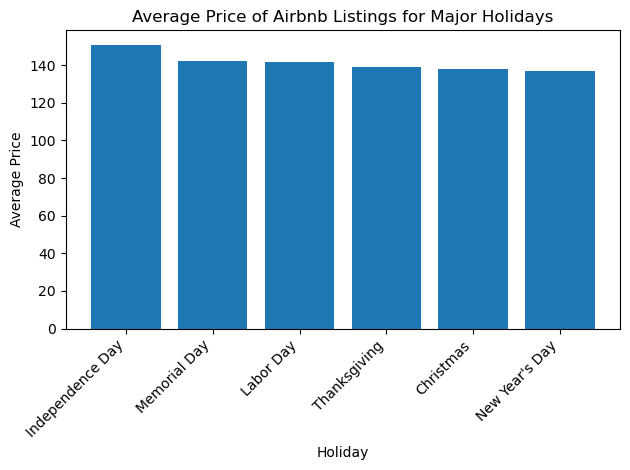

In [30]:
merged = pd.merge(calendar, listings, left_on='listing_id', right_on='id')

holidays = {
    "New Year's Day": ("2017-01-01", "2017-01-02"),
    "Memorial Day": ("2016-05-30", "2016-05-31"),
    "Labor Day": ("2016-09-05", "2016-09-06"),
    "Independence Day": ("2016-07-04", "2016-07-05"),
    "Thanksgiving": ("2016-11-24", "2016-11-25"),
    "Christmas": ("2016-12-25", "2016-12-26")
}

holiday_prices = {}
for holiday, (start_date, end_date) in holidays.items():
    holiday_data = merged[(merged['date'] >= start_date) & (merged['date'] <= end_date) & (merged['price_x'].notna())]
    holiday_data['price_x'] = holiday_data['price_x'].str.replace(',', '').str.replace('$', '').astype(float)
    average_price = holiday_data['price_x'].mean()
    holiday_prices[holiday] = average_price

sorted_holiday_prices = dict(sorted(holiday_prices.items(), key=lambda item: item[1], reverse=True))

plt.bar(sorted_holiday_prices.keys(), sorted_holiday_prices.values())
plt.xlabel('Holiday')
plt.ylabel('Average Price')
plt.title('Average Price of Airbnb Listings for Major Holidays')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Aside from Independence Day, the holidays are really similar in price. Christmas and New Year's Day are the cheapest, but that makes sense due to the fact that winter is the cheapest season.

#### Now, let's break this down by the neighborhoods that are conistently the most expensive and the neighborhoods that have the most listings. This means we will know which neighborhood to look into whether we want one of the nicer listings or whether we want to have a lot of potential options.

/var/folders/l3/c7dty6cx0yv5s4ldhyjnv1hh0000gn/T/ipykernel_4482/4208325695.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  holiday_data['price_x'] = holiday_data['price_x'].str.replace(',', '').str.replace('$', '').astype(float)
/var/folders/l3/c7dty6cx0yv5s4ldhyjnv1hh0000gn/T/ipykernel_4482/4208325695.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holiday_data['price_x'] = holiday_data['price_x'].str.replace(',', '').str.replace('$', '').astype(float)


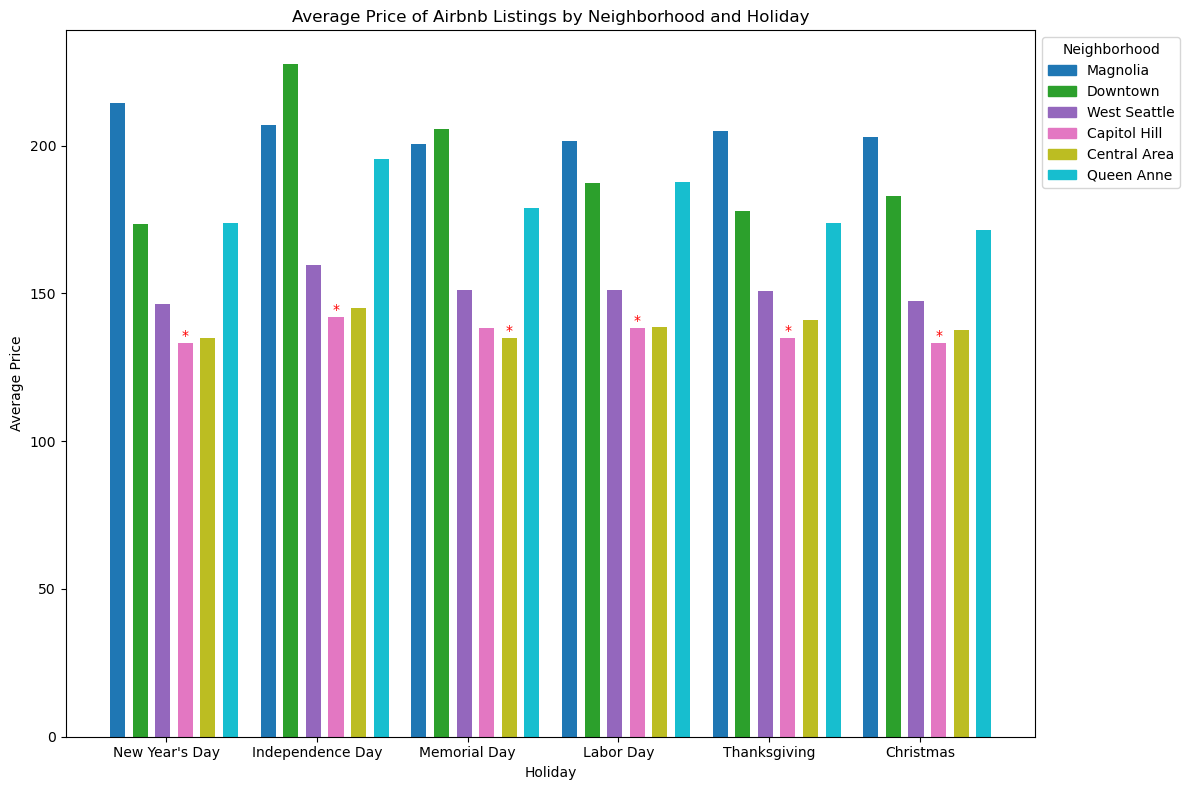

In [31]:
neighborhoods_of_interest = ['Magnolia', 'Downtown', 'West Seattle', 'Capitol Hill', 'Central Area', 'Queen Anne']

merged = pd.merge(calendar, listings, left_on='listing_id', right_on='id')

merged = merged[merged['neighborhood'].isin(neighborhoods_of_interest)]

holidays = {
    "New Year's Day": ("2017-01-01", "2017-01-02"),
    "Independence Day": ("2016-07-04", "2016-07-05"),
    "Memorial Day": ("2016-05-30", "2016-05-31"),
    "Labor Day": ("2016-09-05", "2016-09-06"),
    "Thanksgiving": ("2016-11-24", "2016-11-25"),
    "Christmas": ("2016-12-25", "2016-12-26")
}

holiday_prices = {holiday: {} for holiday in holidays}
for neighborhood in neighborhoods_of_interest:
    for holiday, (start_date, end_date) in holidays.items():
        holiday_data = merged[(merged['date'] >= start_date) & (merged['date'] <= end_date) & (merged['price_x'].notna()) & (merged['neighborhood'] == neighborhood)]
        holiday_data['price_x'] = holiday_data['price_x'].str.replace(',', '').str.replace('$', '').astype(float)
        average_price = holiday_data['price_x'].mean()
        holiday_prices[holiday][neighborhood] = average_price

cheapest_neighborhoods = {holiday: min(holiday_data.items(), key=lambda x: x[1])[0] for holiday, holiday_data in holiday_prices.items()}

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.1
gap = 0.05
colors = plt.cm.tab10(np.linspace(0, 1, len(neighborhoods_of_interest)))

for i, (neighborhood, color) in enumerate(zip(neighborhoods_of_interest, colors)):
    bar_positions = np.arange(len(holidays)) + i * (bar_width + gap)
    for j, (holiday, prices) in enumerate(holiday_prices.items()):
        ax.bar(bar_positions[j], prices[neighborhood], bar_width, color=color)
        if neighborhood == cheapest_neighborhoods[holiday]:
            ax.text(bar_positions[j], prices[neighborhood], "*", ha='center', va='bottom', color='red')

legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
legend_labels = neighborhoods_of_interest
ax.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title='Neighborhood')

ax.set_xlabel('Holiday')
ax.set_ylabel('Average Price')
ax.set_title('Average Price of Airbnb Listings by Neighborhood and Holiday')
ax.set_xticks(np.arange(len(holidays)) + (len(neighborhoods_of_interest) * bar_width + gap) / 2)
ax.set_xticklabels(holidays.keys())

plt.tight_layout()
plt.show()

#### Central Area and Capitol Hill go back and forth on being the cheapest, but West Seattle is also in the mix here. Of the nicer options, Magnolia is the most expensive for each holiday aside from Independence Day. Downtown becomes the most expensive that day. Of the three most expensive options, Downtown is only less expensive than Queen Anne on Labor Day and New Year's Day. These look to be the best times to get a Downtown Airbnb in comparison to other neighborhoods' prices.

#### Now let's graph just the difference in prices between the holiday price for each neighborhood and that neighborhood's average daily price. This will tell us which holidays are way more expensive than that neighborhood's average and which holidays are a good deal for that neighborhood.

/var/folders/l3/c7dty6cx0yv5s4ldhyjnv1hh0000gn/T/ipykernel_4482/4203589209.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  average_prices = {neighborhood: merged[(merged['neighborhood'] == neighborhood) & (merged['price_x'].notna())]['price_x'].astype(str).str.replace(',', '').str.replace('$', '').astype(float).mean() for neighborhood in neighborhoods_of_interest}
/var/folders/l3/c7dty6cx0yv5s4ldhyjnv1hh0000gn/T/ipykernel_4482/4203589209.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  holiday_prices = {holiday: {neighborhood: merged[(merged['date'] >= start_date) & (merged['date'] <= end_date) & (merged['price_x'].notna()) & (merged['neighborhood'] == neighborhood)]['

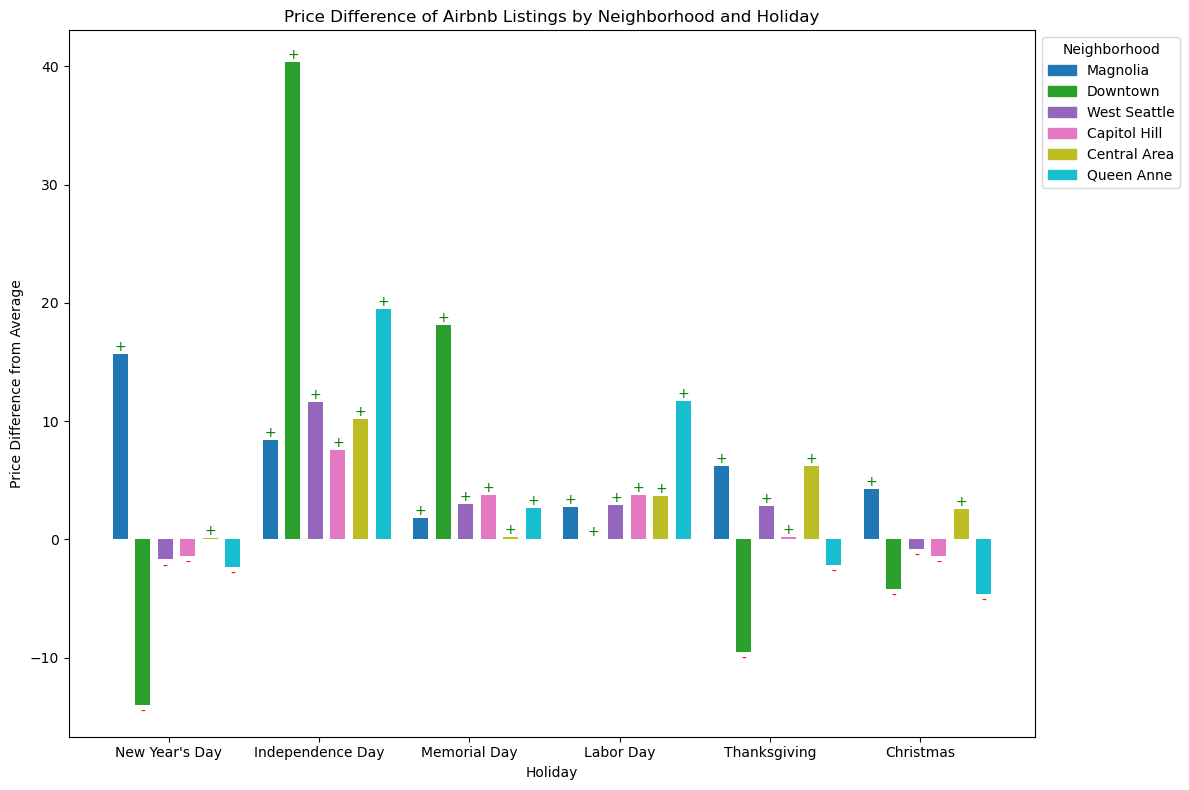

In [32]:
average_prices = {neighborhood: merged[(merged['neighborhood'] == neighborhood) & (merged['price_x'].notna())]['price_x'].astype(str).str.replace(',', '').str.replace('$', '').astype(float).mean() for neighborhood in neighborhoods_of_interest}

holiday_prices = {holiday: {neighborhood: merged[(merged['date'] >= start_date) & (merged['date'] <= end_date) & (merged['price_x'].notna()) & (merged['neighborhood'] == neighborhood)]['price_x'].astype(str).str.replace(',', '').str.replace('$', '').astype(float).mean() for neighborhood in neighborhoods_of_interest} for holiday, (start_date, end_date) in holidays.items()}

price_differences = {holiday: {neighborhood: holiday_prices[holiday][neighborhood] - avg_price for neighborhood, avg_price in average_prices.items()} for holiday in holidays}

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.1
gap = 0.05
colors = plt.cm.tab10(np.linspace(0, 1, len(neighborhoods_of_interest)))

for i, (neighborhood, color) in enumerate(zip(neighborhoods_of_interest, colors)):
    bar_positions = np.arange(len(holidays)) + i * (bar_width + gap)
    for j, (holiday, differences) in enumerate(price_differences.items()):
        ax.bar(bar_positions[j], differences[neighborhood], bar_width, color=color)
        if differences[neighborhood] > 0:
            ax.text(bar_positions[j], differences[neighborhood], "+", ha='center', va='bottom', color='green')
        elif differences[neighborhood] < 0:
            ax.text(bar_positions[j], differences[neighborhood], "-", ha='center', va='top', color='red')

legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
legend_labels = neighborhoods_of_interest
ax.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title='Neighborhood')

ax.set_xlabel('Holiday')
ax.set_ylabel('Price Difference from Average')
ax.set_title('Price Difference of Airbnb Listings by Neighborhood and Holiday')
ax.set_xticks(np.arange(len(holidays)) + (len(neighborhoods_of_interest) * bar_width + gap) / 2)
ax.set_xticklabels(holidays.keys())

plt.tight_layout()
plt.show()

#### New Year's Day and Thanksgiving have really good prices for Downtown. Capitol Hill and Queen Anne also have really good prices on New Year's Day and Christmas. Independence Day is a horrible time to book for every neighborhood. Memorial Day is horrible for Downtown and Labor Day is horrible for Queen Anne.

<a id='days-of-the-week'></a>

## What's the best day of the week?

#### Let's try to determine which days of the week have the best value. First, we should graph the average price for each day of the week.

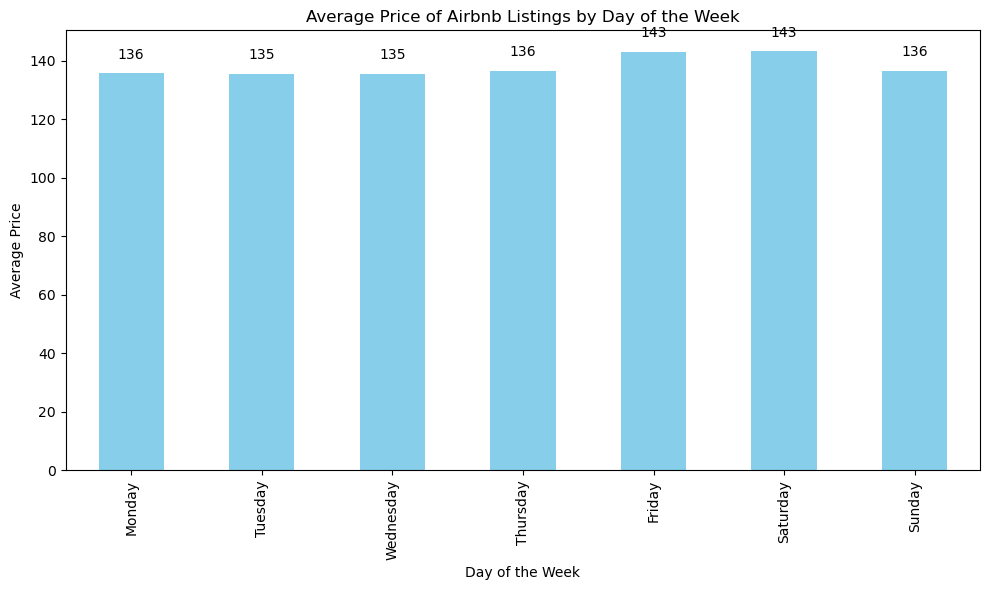

In [33]:
calendar['date'] = pd.to_datetime(calendar['date'])

calendar['day_of_week'] = calendar['date'].dt.day_name()

calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

average_prices = calendar.groupby('day_of_week')['price'].mean()

days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

average_prices = average_prices.reindex(days_of_week_order)

fig, ax = plt.subplots(figsize=(10, 6))

average_prices.plot(kind='bar', ax=ax, color='skyblue')

for i, v in enumerate(average_prices):
    ax.text(i, v + 5, str(round(v)), color='black', ha='center')

ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Price')
ax.set_title('Average Price of Airbnb Listings by Day of the Week')

plt.tight_layout()
plt.show()

#### Friday and Saturday are the most expensive days of the week, but the rest of the week is pretty homogeneous.

#### Once again, let's see the price of different neighborhoods for each day of the week along with the difference in price from its average.

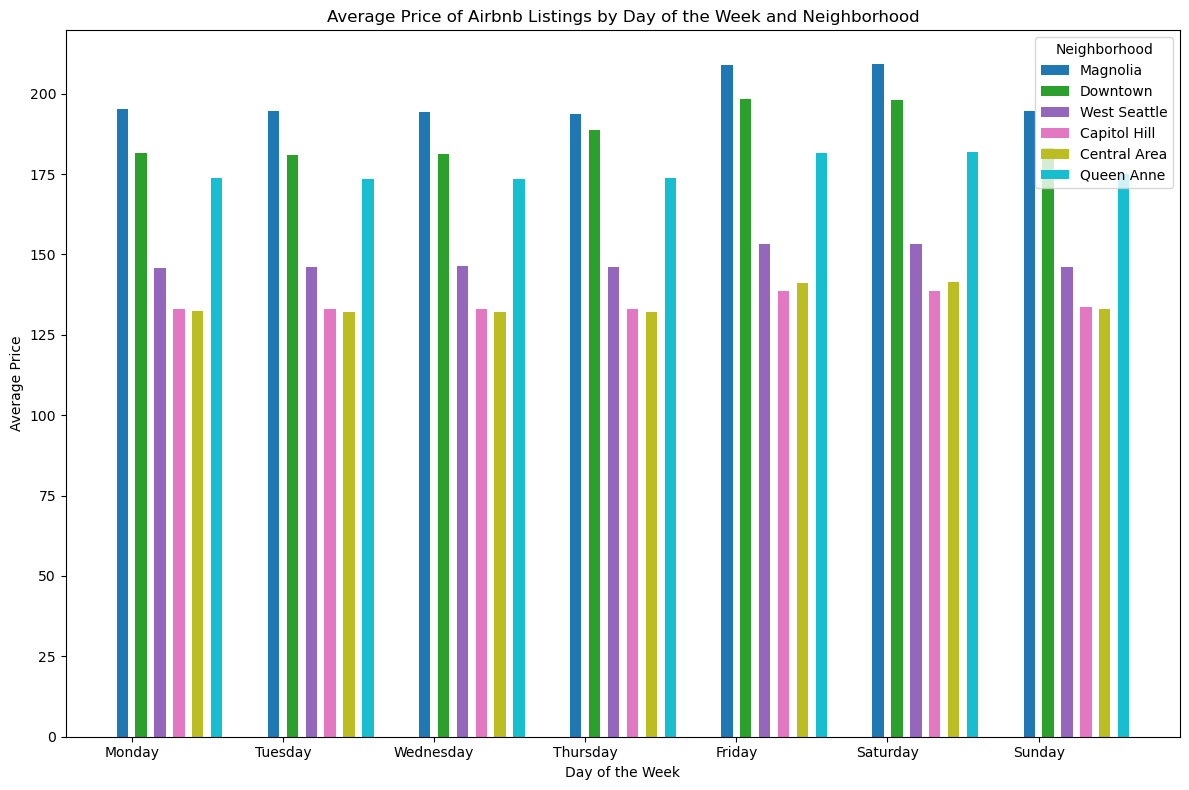

In [34]:
merged = pd.merge(calendar, listings, left_on='listing_id', right_on='id')

merged['date'] = pd.to_datetime(merged['date'])
merged['day_of_week'] = merged['date'].dt.day_name()

neighborhoods_of_interest = ['Magnolia', 'Downtown', 'West Seattle', 'Capitol Hill', 'Central Area', 'Queen Anne']

merged_neighborhoods = merged[merged['neighborhood'].isin(neighborhoods_of_interest)]

average_prices = merged_neighborhoods.groupby(['day_of_week', 'neighborhood'])['price_x'].mean().unstack()
average_prices = average_prices.reindex(days_of_week_order)

fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(neighborhoods_of_interest)))

gap = 0.05

bar_width = (0.7 - (len(neighborhoods_of_interest) - 1) * gap) / len(neighborhoods_of_interest)

for i, (neighborhood, color) in enumerate(zip(neighborhoods_of_interest, colors)):
    positions = np.arange(len(average_prices)) + (i - 0.5) * (bar_width + gap)
    ax.bar(positions, average_prices[neighborhood], width=bar_width, color=color, label=neighborhood)
    
ax.set_xticks(np.arange(len(average_prices)))
ax.set_xticklabels(average_prices.index)

ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Price')
ax.set_title('Average Price of Airbnb Listings by Day of the Week and Neighborhood')
ax.legend(title='Neighborhood')

plt.tight_layout()
plt.show()

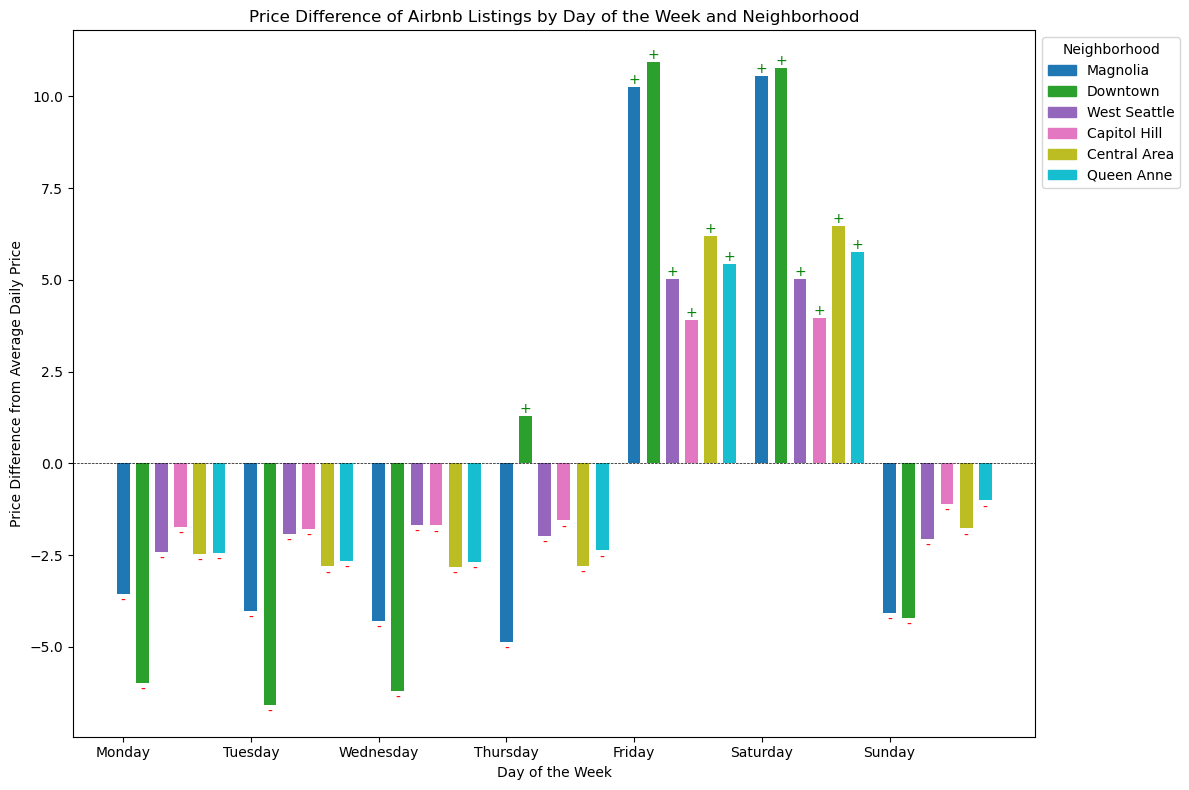

In [35]:
average_daily_prices = average_prices.mean()

price_differences = average_prices.sub(average_daily_prices, axis=1)

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.1
gap = 0.05
colors = plt.cm.tab10(np.linspace(0, 1, len(neighborhoods_of_interest)))

for i, (neighborhood, color) in enumerate(zip(neighborhoods_of_interest, colors)):
    bar_positions = np.arange(len(price_differences)) + i * (bar_width + gap)
    for j, (day, differences) in enumerate(price_differences.iterrows()):
        ax.bar(bar_positions[j], differences[neighborhood], bar_width, color=color)
        if differences[neighborhood] > 0:
            ax.text(bar_positions[j], differences[neighborhood], "+", ha='center', va='bottom', color='green')
        elif differences[neighborhood] < 0:
            ax.text(bar_positions[j], differences[neighborhood], "-", ha='center', va='top', color='red')

legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
legend_labels = neighborhoods_of_interest
ax.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title='Neighborhood')

ax.set_xticks(np.arange(len(average_prices)))
ax.set_xticklabels(average_prices.index)

ax.set_xlabel('Day of the Week')
ax.set_ylabel('Price Difference from Average Daily Price')
ax.set_title('Price Difference of Airbnb Listings by Day of the Week and Neighborhood')

ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

#### Downtown is more expensive than its average three days out of the week, the only neighborhood to be that way. Downtown and Magnolia are much cheaper than their average most days of the week, but Fridays and Saturdays are the most expensive days all around for every neighborhood.

 <a id='host-listings'></a>

## Number of Host's Listings' Impact on the Listing's Rating
### Hypothesis: Owning more listings causes a host to spread themselves too thin, so their listings are not as well maintained as a listing where the host only has that one listing to take care of.

#### It could be worth looking into some factors that reflect on the Airbnb's rating. Let's look at the number of listings owned by the host vs. the listing's rating.

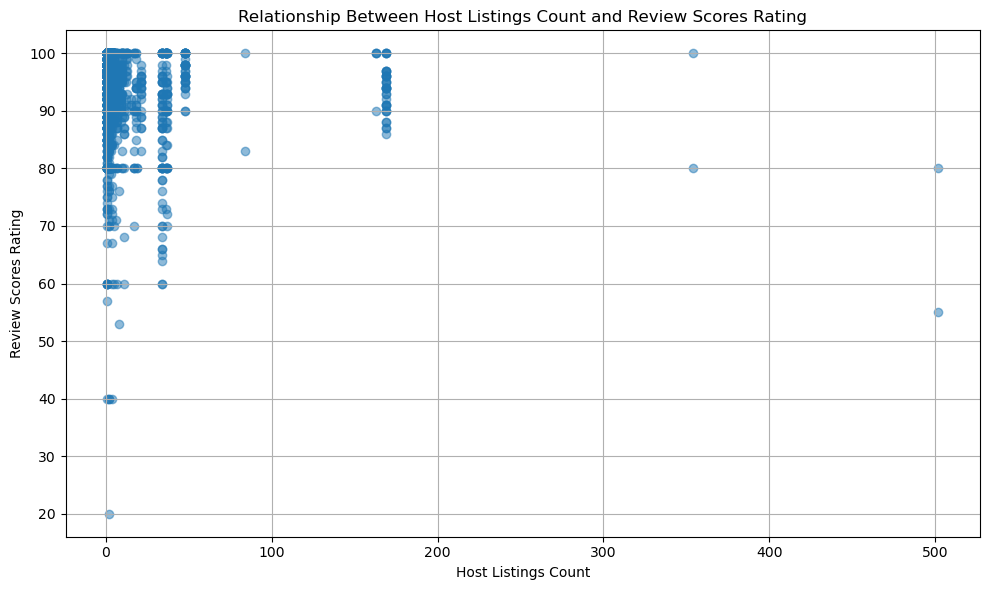

In [36]:
listings = listings.dropna(subset=['review_scores_rating'])

plt.figure(figsize=(10, 6))
plt.scatter(listings['host_listings_count'], listings['review_scores_rating'], alpha=0.5)
plt.title('Relationship Between Host Listings Count and Review Scores Rating')
plt.xlabel('Host Listings Count')
plt.ylabel('Review Scores Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

#### This is hard to decipher, but it looks like there aren't many listings in the dataset past about 20 Host Listings. Let's take a quick look at the spread of the data up to the 20 Host Listings Count point.

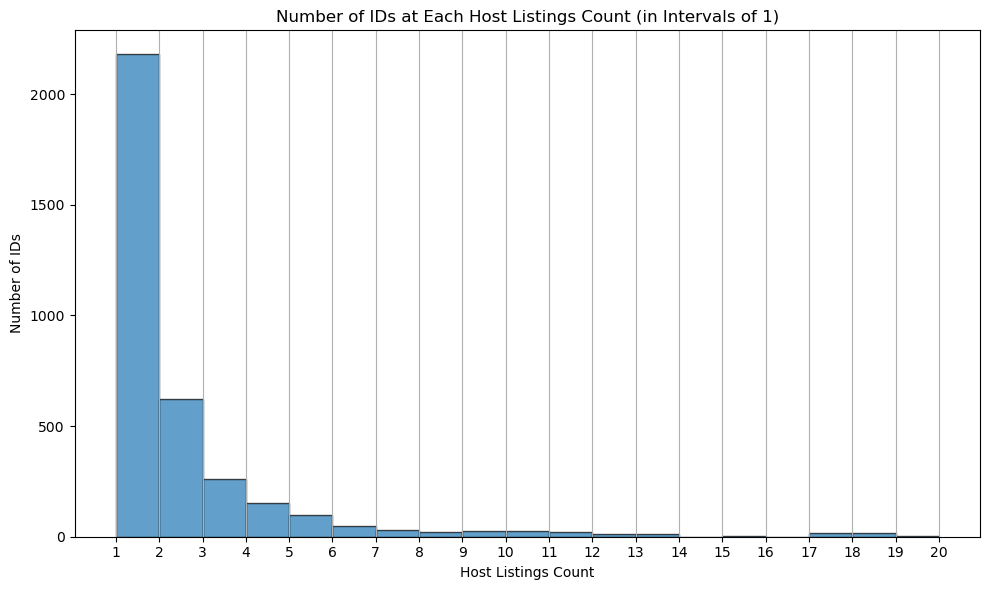

In [37]:
listings = pd.read_csv('listings.csv')

intervals = range(1, 21)

plt.figure(figsize=(10, 6))
listings['host_listings_count'].hist(bins=intervals, edgecolor='black', alpha=0.7)
plt.title('Number of IDs at Each Host Listings Count (in Intervals of 1)')
plt.xlabel('Host Listings Count')
plt.ylabel('Number of IDs')
plt.grid(axis='y')
plt.xticks(intervals)
plt.tight_layout()
plt.show()

#### The data really drops off after 5 listings. Let's compare the number of host listings to ratings within just the hosts with 5 or less listings.

<Figure size 1000x600 with 0 Axes>

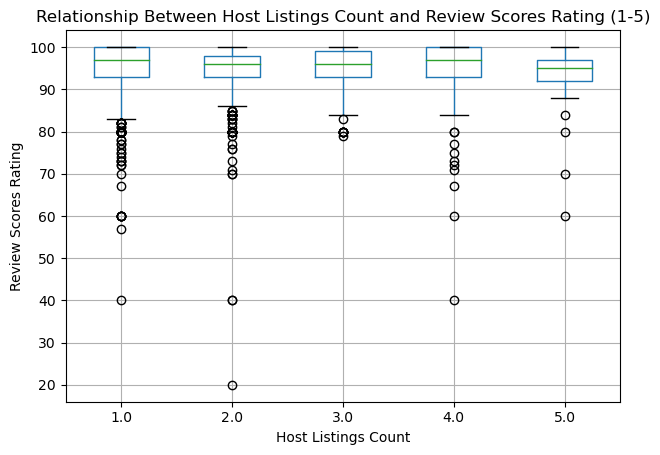

In [38]:
listings = listings.dropna(subset=['review_scores_rating'])

listings_filtered = listings[listings['host_listings_count'].between(1, 5)]

plt.figure(figsize=(10, 6))
boxplot = listings_filtered.boxplot(column='review_scores_rating', by='host_listings_count')
plt.title('Relationship Between Host Listings Count and Review Scores Rating (1-5)')
plt.suptitle('')
plt.xlabel('Host Listings Count')
plt.ylabel('Review Scores Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

#### We can suspect a slight dropoff once a host adds more than one listing, but the range of the data for host's with more than one listing is all over the place. This hypothesis looks to be defunct but we can look at the correlation matrix just to make sure.

In [39]:
listings = listings.dropna(subset=['review_scores_rating'])

correlation_matrix = listings[['host_listings_count', 'review_scores_rating']].corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                      host_listings_count  review_scores_rating
host_listings_count              1.000000             -0.109357
review_scores_rating            -0.109357              1.000000


#### There's only a correlation coefficent of -.109, so it doesn't appear increasing listings has much of an impact on ratings. However, this being a negative relationship does line up with the hypothesis.

<a id='variables-price'></a>

## Impact of Various Variables on Price

#### I want to create a correlation matrix to show the impact various variables have on price. First, let's convert non-numeric variables to numbers.

In [40]:
listings['instant_bookable'].unique()

array(['f', 't'], dtype=object)

In [41]:
listings['host_is_superhost'].unique()

array(['f', 't'], dtype=object)

#### Let's map t and f to 1 and 0 for these two variables.

In [42]:
listings['instant_bookable'] = listings['instant_bookable'].map({'t': 1, 'f': 0})
listings['host_is_superhost'] = listings['host_is_superhost'].map({'t': 1, 'f': 0})

#### Now, let's do bed type. We'll assign a number to each one in increasing order of quality.

In [43]:
listings['bed_type'].unique()

array(['Real Bed', 'Futon', 'Pull-out Sofa', 'Airbed', 'Couch'],
      dtype=object)

In [44]:
listings['bed_type'] = listings['bed_type'].map({'Airbed': 1, 'Couch': 2, 'Futon': 3, 'Pull-out Sofa': 4, 'Real Bed': 5})

#### Next, let's do host response time. We'll order it by quickest response in ascending order.

In [45]:
listings['host_response_time'].unique()

array(['within a few hours', 'within an hour', nan, 'within a day',
       'a few days or more'], dtype=object)

In [46]:
listings['host_response_time'] = listings['host_response_time'].map({'a few days or more': 1, 'within a day': 2, 'within a few hours': 3, 'within an hour': 4})

#### Let's do the same for the cancellation policy in order from least to most lenient.

In [47]:
listings['cancellation_policy'].unique()

array(['moderate', 'strict', 'flexible'], dtype=object)

In [48]:
listings['cancellation_policy'] = listings['cancellation_policy'].map({'strict': 1, 'moderate': 2, 'flexible': 3})

### Correlation Matrix

/var/folders/l3/c7dty6cx0yv5s4ldhyjnv1hh0000gn/T/ipykernel_4482/1398488975.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  filtered_listings['price'] = filtered_listings['price'].str.replace('$', '').str.replace(',', '').astype(float)
/var/folders/l3/c7dty6cx0yv5s4ldhyjnv1hh0000gn/T/ipykernel_4482/1398488975.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_listings['price'] = filtered_listings['price'].str.replace('$', '').str.replace(',', '').astype(float)


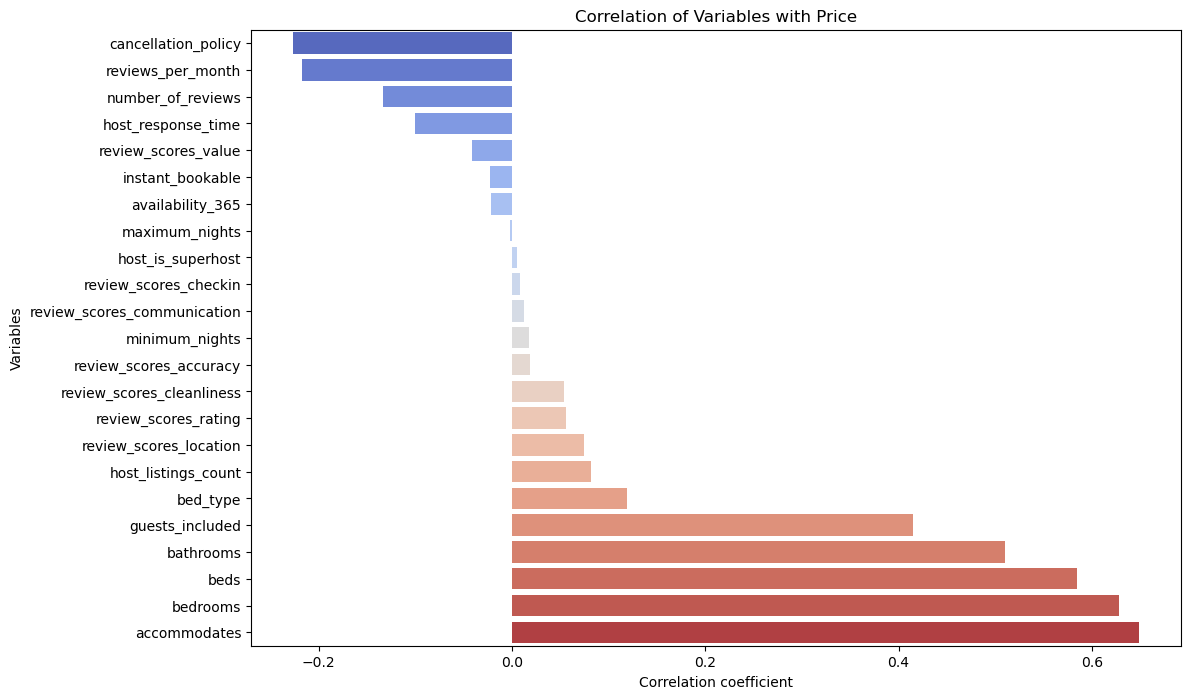

In [49]:
variables_of_interest = [
    'reviews_per_month',
    'review_scores_value',
    'review_scores_location',
    'review_scores_communication',
    'review_scores_checkin',
    'review_scores_cleanliness',
    'review_scores_accuracy',
    'review_scores_rating',
    'number_of_reviews',
    'availability_365',
    'maximum_nights',
    'minimum_nights',
    'guests_included',
    'beds',
    'bedrooms',
    'bathrooms',
    'accommodates',
    'host_listings_count',
    'host_response_time',
    'host_is_superhost',
    'bed_type',
    'instant_bookable',
    'cancellation_policy',
    'price'
]

filtered_listings = listings[variables_of_interest]

filtered_listings['price'] = filtered_listings['price'].str.replace('$', '').str.replace(',', '').astype(float)

price_correlation = filtered_listings.corr()['price'].drop('price')

price_correlation_sorted = price_correlation.sort_values()

plt.figure(figsize=(12, 8))
sns.barplot(x=price_correlation_sorted.values, y=price_correlation_sorted.index, palette='coolwarm')
plt.title('Correlation of Variables with Price')
plt.xlabel('Correlation coefficient')
plt.ylabel('Variables')
plt.show()

#### We could have assumed that number of guests, number of bathrooms, number of bedrooms, and number of beds all have a strong positive impact on price, but it's interesting to see that the leniency of a cancellation policy and the number of reviews decreases a listing's price. Intuitively, the cancellation policy can make sense because listings with a lower price may have lower profit. This means that a late cancellation with no time to find a replacement can hurt that Airbnb owner's bottom line. The number of reviews per motnh may also be negatively correlated because more people can afford to visit cheaper Airbnbs.